In [1]:
import time
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import VarAutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.5.dev2444
Numpy version: 1.26.4
Pytorch version: 2.4.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c70fbd8ff919cabaacfabcbdbf28aa435ae622f9
MONAI __file__: /Users/<username>/miniconda3/envs/rama/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependenc

In [81]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as T
from threelayerRBM import extract_features
import pickle
import numpy as np



class ChestXRayDataset(Dataset):
    def __init__(self, csv_path, root_dir, rbm_model, findings_list, hidden_features_dict,
                 transform=None, vectorizer_v=None, hidden_vectorizers=None):
        """
        csv_path: path to output.csv
        root_dir: './files-1024'
        rbm_model: an instance of ThreeLayerRBM already trained and loaded
        findings_list, hidden_features_dict: from your threelayerRBM.py setup
        transform: torchvision transforms for images
        """
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        self.rbm = rbm_model
        self.findings_list = findings_list
        self.hidden_features_dict = hidden_features_dict

        # Store vectorizers
        self.vectorizer_v = vectorizer_v
        self.hidden_vectorizers = hidden_vectorizers

        # Pre-load vectorizers from your threelayerRBM code (assuming you saved them)
        # If not saved, you must re-create them as done in extract_features()
        # For simplicity, let's assume you have functions or preloaded vectorizers:
        # self.vectorizer_v, self.hidden_vectorizers = load_vectorizers(...)

        # To avoid repeated processing, we can store relevant info
        # We'll store each row's path and text for lazy processing
        self.samples = []
        for _, row in self.df.iterrows():
            level1 = row['Level1']  # e.g. 'p10'
            level2 = row['Level2']  # e.g. 'p10000032'
            file_ = row['File']     # e.g. 's50414267'
            # Construct the image directory
            img_dir = os.path.join(self.root_dir, level1, level2, file_)

            # Extract text
            findings = str(row['FINDINGS']) if not pd.isnull(row['FINDINGS']) else ''
            impression = str(row['IMPRESSION']) if not pd.isnull(row['IMPRESSION']) else ''
            text = findings + ' ' + impression

            self.samples.append((img_dir, text))

    def __len__(self):
        return len(self.samples)

    def preprocess_text(self, text):
        # As in threelayerRBM.py
        import re
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def get_features_from_text(self, clean_text, vectorizer_v, hidden_vectorizers):
        # vectorizer_v is a CountVectorizer for findings
        X_visible = vectorizer_v.transform([clean_text]).toarray()

        hidden_features = []
        for category, vec in hidden_vectorizers.items():
            X_hidden_cat = vec.transform([clean_text]).toarray()
            hidden_features.append(X_hidden_cat)
        X_hidden = np.concatenate(hidden_features, axis=1) if len(hidden_features) > 0 else np.array([])

        return X_visible, X_hidden
    
    def text_to_cond_z(self, text):
        # Convert text to cond_z using RBM
        # 1. Preprocess text
        clean_text = self.preprocess_text(text)

        # 2. Vectorize text to get X_visible and X_hidden (as in threelayerRBM.py extract_features step)
        # Assuming you have vectorizers prepared:
        # X_visible = self.vectorizer_v.transform([clean_text]).toarray()
        # For hidden features:
        # hidden_features = []
        # for category, terms in self.hidden_features_dict.items():
        #     X_hidden_cat = self.hidden_vectorizers[category].transform([clean_text]).toarray()
        #     hidden_features.append(X_hidden_cat)
        # X_hidden = np.concatenate(hidden_features, axis=1)

        # If you do not have them preloaded, you must create vectorizers here or store them from training phase.

        # For demonstration, assume you have a function get_features_from_text that returns X_visible and X_hidden:
        X_visible, X_hidden = self.get_features_from_text(clean_text, self.vectorizer_v, self.hidden_vectorizers)
        # 3. cond_z = rbm.transform(X_visible)
        cond_z = torch.tensor(self.rbm.transform(X_visible), dtype=torch.float32)
        
        return cond_z[0]  # Since batch size = 1 here


    def load_image(self, img_dir):
        # Load one or multiple images from img_dir
        # If there are multiple .jpg images, decide how to handle them
        imgs = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
        if len(imgs) == 0:
            raise FileNotFoundError(f"No image found in {img_dir}")

        # For simplicity, load the first image
        img_path = os.path.join(img_dir, imgs[0])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

    def __getitem__(self, idx):
        img_dir, text = self.samples[idx]

        img = self.load_image(img_dir)
        cond_z = self.text_to_cond_z(text)
        return img, cond_z

from threelayerRBM import ThreeLayerRBM

# Load your RBM model and vectorizers
findings_list = [
    "left", "right", "atelectasis", "bronchiectasis", "bulla", "consolidation", "dextrocardia", "effusion", "emphysema",
    "fracture clavicle", "fracture rib", "groundglass opacity", "interstitial opacification",
    "mass paraspinal", "mass soft tissue", "nodule", "opacity", "pneumomediastinum", "pneumonia",
    "pneumoperitoneum", "pneumothorax", "pleural effusion", "pulmonary edema", "scoliosis",
    "tuberculosis", "volume loss", "rib", "mass", "infiltration", "other findings"
]

hidden_features_dict = {
    'location': [
        "left lung", "right lung", "upper lobe", "lower lobe", "cardiac region",
        "pleural space", "diaphragm", "mediastinum", "thoracic spine", "abdominal region"
    ],
    'organ_system': [
        "respiratory system", "cardiovascular system", "musculoskeletal system", "digestive system"
    ],
    'mode_of_pathology': [
        "congenital", "acquired", "infection", "inflammation", "tumor", "degenerative", "vascular"
    ],
    'severity': [
        "mild", "moderate", "severe",
    ],
}
df = pd.read_csv('output.csv')
X_visible, X_hidden, vectorizer_v, hidden_vectorizers = extract_features(df, findings_list, hidden_features_dict)

n_visible = X_visible.shape[1]
n_hidden_middle = 30
n_hidden_top = X_hidden.shape[1]
rbm = ThreeLayerRBM(n_visible, n_hidden_middle, n_hidden_top)
rbm.load_model('rbm_model.pkl')
with open('vectorizer_v.pkl', 'rb') as f:
    vectorizer_v = pickle.load(f)
with open('hidden_vectorizers.pkl', 'rb') as f:
    hidden_vectorizers = pickle.load(f)

# transforms for images
transform = T.Compose([
    T.Resize((64,64)),
    T.ToTensor(),
])

dataset = ChestXRayDataset(
    csv_path='output.csv',
    root_dir='./files-1024',
    rbm_model=rbm,
    findings_list=findings_list,
    hidden_features_dict=hidden_features_dict,
    transform=transform,
    vectorizer_v=vectorizer_v,
    hidden_vectorizers=hidden_vectorizers
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


Model loaded from rbm_model.pkl


In [5]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create small visualisation function
def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap="gray")
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def get_mednist_data(mednist_folder):
    resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
    md5 = "0bc7306e7427e00ad1c5526a6677552d"

    compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
    if not os.path.exists(mednist_folder):
        download_and_extract(resource, compressed_file, root_dir, md5)

In [ ]:
use_mnist = False
if use_mnist:
    im_dir = os.path.join(root_dir, "MNIST")
    get_mnist_data(im_dir)
else:
    data_dir = os.path.join(root_dir, "MedNIST")
    get_mednist_data(data_dir)
    # could be any combination of
    # ["AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT"]
    scan_types = ["Hand", "HeadCT"]
    all_filenames = []
    for scan_type in scan_types:
        im_dir = os.path.join(data_dir, scan_type)
        all_filenames += [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2, 4))

In [ ]:
# Split into training and testing
test_frac = 0.2
num_ims = len(all_filenames)
num_test = int(num_ims * test_frac)
num_train = num_ims - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {num_ims}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

In [ ]:
batch_size = 128
num_workers = 0

transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
    ]
)

train_ds = CacheDataset(train_datadict, transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [82]:
BCELoss = torch.nn.BCELoss(reduction="sum")


def loss_function(recon_x, x, mu, log_var, beta):
    bce = BCELoss(recon_x, x)
    kld = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kld


def train(in_shape, max_epochs, latent_size, learning_rate, beta, train_loader):
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=in_shape,
        out_channels=3,
        latent_size=latent_size,
        channels=(16, 32, 64),
        strides=(1, 2, 2),
    ).to(device)

    # Create optimiser
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    avg_train_losses = []
    test_losses = []

    t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
    for epoch in t:
        model.train()
        epoch_loss = 0
        i=0
        for batch_data, cond_zs in train_loader:
            inputs = batch_data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var, _ = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var, beta)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            i+=1
            if i>= 2775:
                break
        avg_train_losses.append(epoch_loss /i)

        t.set_description(  # noqa: B038
            f"epoch {epoch + 1}, average train loss: " f"{avg_train_losses[-1]:.4f}"
        )
    return model, avg_train_losses

In [91]:
max_epochs = 20
learning_rate = 1e-4
beta = 100  # KL beta weighting. increase for disentangled VAE
latent_size = 24
# VAE constructor needs image shape
for imgs, cond_zs in dataloader:
    # imgs: Tensor [B, C, H, W]
    # cond_zs: Tensor [B, cond_z_dim]
    # Feed into NVAE
    # 7550*5+1*3 imags
    im_shape = imgs[0].shape
    # process further as needed
    break
model, avg_train_losses = train(im_shape, max_epochs, latent_size, learning_rate, beta, dataloader)

epoch 20, average train loss: 56951.6208: 100%|██████████| 20/20 [53:23<00:00, 160.17s/it]


In [92]:
torch.save({'epoch': max_epochs, 'state_dict': model.state_dict(),}, 'normal_vae_64_20epoch.pt')

Montage saved to generated_montage_64_vae_50epoch.png


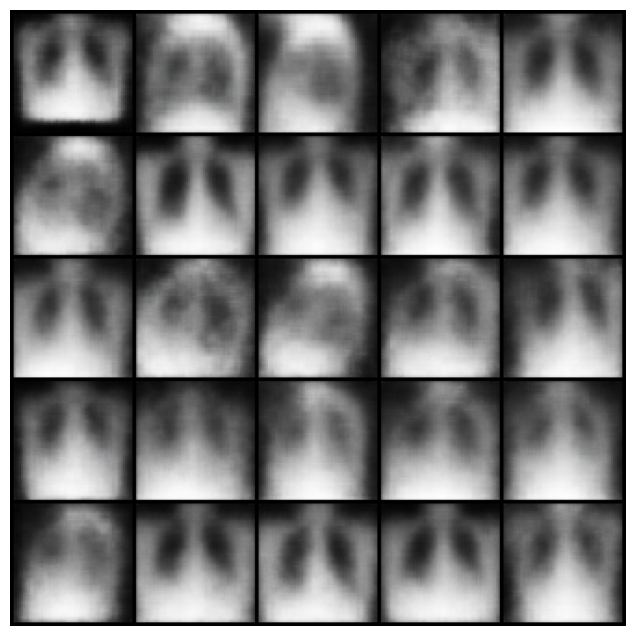

In [93]:
import torchvision.utils as vutils

def generate_montage(vae_model, latent_size, grid_size=5, save_path=None):
    """
    Generate a 5x5 montage of images decoded from random latent vectors.

    Args:
        vae_model: Trained VarAutoEncoder model.
        latent_size: Size of the latent space.
        grid_size: Size of the grid (default is 5x5).
        save_path: Optional path to save the montage image (e.g., 'generated_montage.png').

    Returns:
        None. Displays and optionally saves the montage.
    """
    vae_model.eval()  # Set the model to evaluation mode

    # Sample random latent vectors
    latent_vectors = torch.randn(grid_size**2, latent_size).to(device)

    # Decode the latent vectors
    with torch.no_grad():
        decoded_images = vae_model.decode_forward(latent_vectors).cpu()

    # Ensure images are in the correct range
    decoded_images = decoded_images.clamp(0, 1)

    # Save the montage if a save path is provided
    if save_path:
        vutils.save_image(decoded_images, save_path, nrow=grid_size, normalize=True)
        print(f"Montage saved to {save_path}")

    # Display the montage
    grid_img = vutils.make_grid(decoded_images, nrow=grid_size, normalize=True).permute(1, 2, 0).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()

# Example usage:
# Assuming `model` is the trained VAE and `latent_size` is the latent dimension size
def load_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=im_shape,
        out_channels=3,
        latent_size=latent_size,
        channels=(16, 32, 64),
        strides=(1, 2, 2),
    ).to(device)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.eval()
    return model
#model = load_model('normal_vae_64.pt')
generate_montage(model, latent_size=24, grid_size=5, save_path='generated_montage_64_vae_50epoch.png')


In [94]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a trained VAE model named `model`
model.eval()  # Set the model to evaluation mode

num_samples_kl = 500  # Number of samples for KL divergence calculation
kls = []
orig_list = []
gen_list = []

# Define KL divergence function
def kl_divergence(original, generated):
    """Compute the KL divergence between two images."""
    original = original + 1e-10  # Add small value to avoid log(0)
    generated = generated + 1e-10
    kl = original * (torch.log(original) - torch.log(generated))
    return torch.sum(kl)

with torch.no_grad():
    for i, (imgs, _) in enumerate(dataloader):
        if len(orig_list) >= num_samples_kl:
            break

        imgs = imgs.to(device)  # Move images to the same device as the model
        orig_imgs = imgs.cpu().float()  # Keep original images on CPU for comparison

        # Encode and decode using the VAE
        _, mu, logvar, z = model(imgs)  # Forward pass through the VAE
        gen_imgs = model.decode_forward(z).cpu().float()  # Decode latent space to images

        # Store original and generated images
        orig_list.extend(orig_imgs)  # Append batch of original images
        gen_list.extend(gen_imgs)  # Append batch of generated images

        # Calculate KL divergence for each image in the batch
        for orig_img, gen_img in zip(orig_imgs, gen_imgs):
            kl_value = kl_divergence(orig_img.squeeze(), gen_img.squeeze())
            kls.append(kl_value.item())

# Report the average KL divergence
avg_kl = sum(kls) / len(kls)
print("Average KL divergence over first 500 samples:", avg_kl)


Average KL divergence over first 500 samples: 661.3852691650391


In [90]:
import torch
import torchvision.transforms as T
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d

# Preprocess for inception
def inception_preprocess(img):
    if img.dim() == 2:
        img = img.unsqueeze(0)
    if img.size(0) == 1:
        img = img.repeat(3, 1, 1)
    pil = T.ToPILImage()(img)
    transform = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    return transform(pil)

# Inception Score
def inception_score(imgs, splits=10):
    N = imgs.size(0)
    batch_size = 50
    preds = []
    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = imgs[i:i + batch_size]
            out = inception(batch)
            p_yx = F.softmax(out, dim=1)
            preds.append(p_yx)
    preds = torch.cat(preds, dim=0)
    split_size = N // splits
    is_scores = []
    for k in range(splits):
        part = preds[k * split_size:(k + 1) * split_size, :]
        py = part.mean(dim=0)
        scores = (part * (torch.log(part + 1e-8) - torch.log(py + 1e-8))).sum(dim=1).mean()
        is_scores.append(torch.exp(scores))
    return sum(is_scores) / len(is_scores)

# Get activations for FID
def get_activations(imgs, model, batch_size=50):
    model.Mixed_7c.register_forward_hook(lambda m, i, o: setattr(model, '_hidden', o))
    activations = []
    with torch.no_grad():
        for i in range(0, imgs.size(0), batch_size):
            batch = imgs[i:i + batch_size]
            _ = model(batch)
            feat = adaptive_avg_pool2d(model._hidden, (1, 1)).squeeze(-1).squeeze(-1)
            activations.append(feat)
    return torch.cat(activations, dim=0).cpu().numpy()

# FID computation
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if not np.isfinite(covmean).all():
        covmean = np.nan_to_num(covmean)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_statistics(acts):
    mu = np.mean(acts, axis=0)
    sigma = np.cov(acts, rowvar=False)
    return mu, sigma

# Evaluation Loop
model.eval()
orig_list = []
gen_list = []
with torch.no_grad():
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        orig_imgs = imgs.cpu().float()
        _, mu, logvar, z = model(imgs)
        gen_imgs = model.decode_forward(z).cpu().float()
        orig_list.extend(orig_imgs)
        gen_list.extend(gen_imgs)
        if len(orig_list) >= 500:  # Limit to 500 samples
            break

# Preprocess for Inception
orig_batch = torch.stack([inception_preprocess(im) for im in orig_list], dim=0)
gen_batch = torch.stack([inception_preprocess(im) for im in gen_list], dim=0)

# Load Inception model
inception = inception_v3(pretrained=True, transform_input=False).eval().to(device)

# Compute Inception Score
IS = inception_score(gen_batch, splits=10)
print("Inception Score:", IS)

# Compute FID
activations_real = get_activations(orig_batch, inception)
activations_fake = get_activations(gen_batch, inception)
mu_r, sigma_r = compute_statistics(activations_real)
mu_g, sigma_g = compute_statistics(activations_fake)
FID = calculate_fid(mu_r, sigma_r, mu_g, sigma_g)
print("FID:", FID)


/Users/paussava/miniconda3/envs/rama/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/paussava/miniconda3/envs/rama/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: tensor(1.5616)
FID: 318.27934405320923
